# Webcrawl
ref: https://github.com/openai/openai-cookbook/blob/main/apps/web-crawl-q-and-a/web-qa.ipynb

In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

/home/lkk/miniconda3/envs/mypy310/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.2.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [27]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "sjsu.edu"
full_url = "https://www.sjsu.edu/cmpe/"
subdomain = "/cmpe"

In [45]:
url_obj = urlparse("https://www.sjsu.edu/cmpe/research/tdd.pdf")
url_obj

ParseResult(scheme='https', netloc='www.sjsu.edu', path='/cmpe/research/tdd.pdf', params='', query='', fragment='')

In [46]:
url_obj.path.startswith("/cmpe")

True

In [47]:
url_obj.path.endswith(".pdf")

True

In [48]:
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        #The <a> tag defines a hyperlink
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

#takes a URL as an argument, opens the URL, and reads the HTML content. Then, it returns all the hyperlinks found on that page.
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url, subdomain=""):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                if subdomain:
                    if url_obj.path.startswith(subdomain):
                        #print("match subdomain")
                        clean_link = link
                else:
                    clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            #print("relative link", link)
            if subdomain:
                if not link.startswith(subdomain):
                    continue
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            if clean_link.endswith(".pdf") or clean_link.endswith(".jpg") or clean_link.endswith(".png"):
                 continue
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [9]:
os.getcwd()

'/home/lkk/Developer/DeepDataMiningLearning/dataapps'

In [32]:
outputpath="./output"
os.mkdir(outputpath)
textoutputpath=os.path.join(outputpath,"text/")
textoutputpath

'./output/text/'

In [13]:
textoutputpath+local_domain+"/"

'./output/text/www.sjsu.edu/'

In [11]:
local_domain = urlparse(full_url).netloc

In [12]:
local_domain

'www.sjsu.edu'

In [50]:
#crawl the given url and output text files in textoutputpath
def crawl(url, textoutputpath, subdomain=""):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists(textoutputpath):
            os.mkdir(textoutputpath)

    if not os.path.exists(textoutputpath+local_domain+"/"):
            os.mkdir(textoutputpath + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists(textoutputpath+"processed"):
            os.mkdir(textoutputpath+"processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open(textoutputpath+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url, subdomain):
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [51]:
subdomain

'/cmpe'

In [52]:
crawl(full_url, textoutputpath, subdomain)

https://www.sjsu.edu/cmpe/
https://www.sjsu.edu/cmpe/faculty/lecturer/brett-hartbeck.php
https://www.sjsu.edu/cmpe
https://www.sjsu.edu/cmpe/faculty
https://www.sjsu.edu/cmpe/students/undergraduate-advising/cpt-guide-undergraduates.php
https://www.sjsu.edu/cmpe/students/undergraduate-advising
https://www.sjsu.edu/cmpe/students/undergraduate-advising/undergraduate-changeofmajor.php#faq
https://www.sjsu.edu/cmpe/students/undergraduate-advising/undergraduate-changeofmajor.php#reviewguide
https://www.sjsu.edu/cmpe/students/undergraduate-advising/undergraduate-changeofmajor.php#studentguide
https://www.sjsu.edu/cmpe/students
https://www.sjsu.edu/cmpe/academic/ms-cmpe/msce-faq.php
https://www.sjsu.edu/cmpe/academic/ms-cmpe
https://www.sjsu.edu/cmpe/academic
https://www.sjsu.edu/cmpe/students/graduate-advising/credit-transfer.php
https://www.sjsu.edu/cmpe/students/graduate-advising
https://www.sjsu.edu/cmpe/faculty/advisors/index.php
HTTP Error 404: Not Found
https://www.sjsu.edu/cmpe/student

ConnectTimeout: HTTPSConnectionPool(host='www.sjsu.edu', port=443): Max retries exceeded with url: /cmpe/research/project-expo/index.php (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f8d5fec79d0>, 'Connection to www.sjsu.edu timed out. (connect timeout=None)'))

CSV is a common format for storing embeddings. You can use this format with Python by converting the raw text files (which are in the text directory) into Pandas data frames.

Converting the text to CSV requires looping through the text files in the text directory created earlier. After opening each file, remove the extra spacing and append the modified text to a list. Then, add the text with the new lines removed to an empty Pandas data frame and write the data frame to a CSV file.

In [53]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [54]:
textoutputpath

'./output/text/'

In [56]:
domain

'sjsu.edu'

In [76]:
import pandas as pd
import csv
def processtxtfiles(inputfolder, outputpath):
    # Create a list to store the text files
    texts=[]

    if not os.path.exists(outputpath):
        os.mkdir(outputpath)


    # Get all the text files in the text directory
    for file in os.listdir(inputfolder + "/"):
        if file.endswith("doc.txt") or file.endswith("docx.txt"):
            continue
        # Open the file and read the text
        with open(inputfolder + "/" + file, "r") as f:
            text = f.read()

            # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
            texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

    # Create a dataframe from the list of texts
    df = pd.DataFrame(texts, columns = ['fname', 'text'])

    # Set the text column to be the raw text with the newlines removed
    df['text'] = df.fname + ". " + remove_newlines(df.text)
    df.to_csv(outputpath+'/scraped.csv', escapechar='\\')
    #csv.writer(f, quoting=csv.QUOTE_NONE, delimiter='|', quotechar='',escapechar='\\')    #Or any other appropriate escapechar
    return df

In [77]:
inputfolder="./output/text/www.sjsu.edu"
outputpath="./output/text/processed"
df=processtxtfiles(inputfolder, outputpath)

/tmp/ipykernel_23999/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


In [78]:
df.head()

,fname,text
0,u cmpe faculty faculty emeriti ron mak.php,u cmpe faculty faculty emeriti ron mak.php. ...
1,u cmpe faculty tenure line ahmet bindal.php,u cmpe faculty tenure line ahmet bindal.php. ...
2,u cmpe research research areas,u cmpe research research areas. Research A...
3,u cmpe academic cybersecurity program cybersec...,u cmpe academic cybersecurity program cybersec...
4,u cmpe academic bs software engineering bsse f...,u cmpe academic bs software engineering bsse f...


In [79]:
df['fname'][3]

'u cmpe academic cybersecurity program cybersecuritycertificatesprogram.php'

In [80]:
df['text'][3]

"u cmpe academic cybersecurity program cybersecuritycertificatesprogram.php.     Cybersecurity Foundations Certificates Program Course Requirements | Computer Engineering   Skip to main content  San José State University  Menu  Visit Campus Tours Maps Parking Silicon Valley Hammer Theatre SJSU Loves SJ Academics Colleges and Departments Majors and Programs Academic Calendar Classes King Library Admissions Tuition and Fees Housing Professional Education Parent and Family Programs Campus Life Health and Wellness Safety SJSU Cares Events Traditions Student Alumni Connection Research and Innovation Office of Research Office of Innovation Research Foundation Student-Faculty Collaborations Become a Research Partner Centers and Institutes About Administration and Leadership Facts and Accomplishments NewsCenter Partnerships Transformation Defined  SJSU Online Athletics Alumni Association Giving to SJSU Canvas one.SJSU  Search    University Menu .Go toSJSU homepage.  Visit Campus Tours Maps Par

In [81]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

In [82]:
df0 = pd.read_csv(outputpath+'/scraped.csv', index_col=0)
df0.head()

,fname,text
0,u cmpe faculty faculty emeriti ron mak.php,u cmpe faculty faculty emeriti ron mak.php. ...
1,u cmpe faculty tenure line ahmet bindal.php,u cmpe faculty tenure line ahmet bindal.php. ...
2,u cmpe research research areas,u cmpe research research areas. Research A...
3,u cmpe academic cybersecurity program cybersec...,u cmpe academic cybersecurity program cybersec...
4,u cmpe academic bs software engineering bsse f...,u cmpe academic bs software engineering bsse f...


In [91]:
df0.columns = ['title', 'text']
df0.head()

,title,text
0,u cmpe faculty faculty emeriti ron mak.php,u cmpe faculty faculty emeriti ron mak.php. ...
1,u cmpe faculty tenure line ahmet bindal.php,u cmpe faculty tenure line ahmet bindal.php. ...
2,u cmpe research research areas,u cmpe research research areas. Research A...
3,u cmpe academic cybersecurity program cybersec...,u cmpe academic cybersecurity program cybersec...
4,u cmpe academic bs software engineering bsse f...,u cmpe academic bs software engineering bsse f...


In [92]:
len(df0)

102

<Axes: >

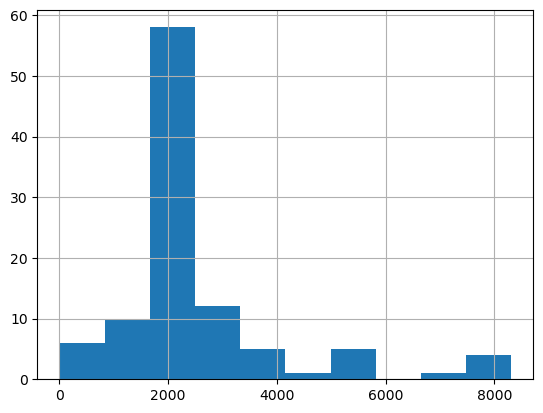

In [93]:
# Tokenize the text and save the number of tokens to a new column
df0['n_tokens'] = df0.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df0.n_tokens.hist()

In [94]:
df0.head()

,title,text,n_tokens
0,u cmpe faculty faculty emeriti ron mak.php,u cmpe faculty faculty emeriti ron mak.php. ...,2003
1,u cmpe faculty tenure line ahmet bindal.php,u cmpe faculty tenure line ahmet bindal.php. ...,2027
2,u cmpe research research areas,u cmpe research research areas. Research A...,2017
3,u cmpe academic cybersecurity program cybersec...,u cmpe academic cybersecurity program cybersec...,2520
4,u cmpe academic bs software engineering bsse f...,u cmpe academic bs software engineering bsse f...,2698


In [95]:
len(df0)

102

split the longer lines into smaller chunks

In [96]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df0.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

Visualizing the updated histogram again can help to confirm if the rows were successfully split into shortened sections.

<Axes: >

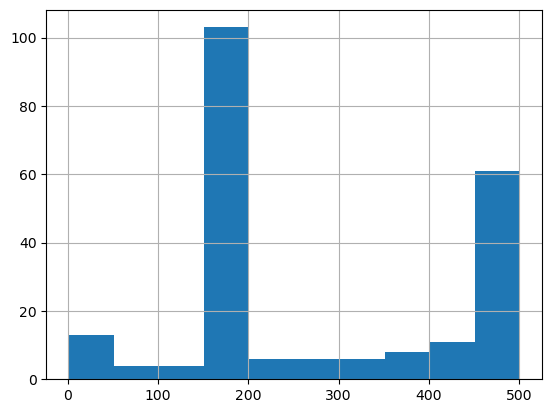

In [97]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [98]:
df.head()

,text,n_tokens
0,u cmpe faculty faculty emeriti ron mak.php. ...,160
1,u cmpe faculty tenure line ahmet bindal.php. ...,161
2,.,1
3,u cmpe research research areas. Research A...,154
4,u cmpe academic cybersecurity program cybersec...,165


In [99]:
len(df)

222

In [100]:
sum(df['n_tokens'])

59379

In [ ]:
df['']

The content is now broken down into smaller chunks and a simple request can be sent to the OpenAI API specifying the use of the new text-embedding-ada-002 model to create the embeddings:

In [101]:
outputpath

'./output/text/processed'

In [104]:
df[8:10]

,text,n_tokens
8,CMPE 195A (2 units) has to be taken concurre...,171
9,u cmpe research project expo 2020 spring.php. ...,163


In [102]:
df.to_csv(outputpath+'/split.csv', escapechar='\\')